# Forest Cover Classification
By Joshua Johnston

Overview:
In this project i am creating a deep learning model via the tensorflow and keras packages to classify different types of forrest cover in four forest areas located in the Roosevelt National Forest of northern Colorado. The cover types include:
* Spruce/Fir
* Lodgepole Pine
* Ponderosa Pine
* Cottonwood/Willow
* Aspen
* Douglas-fir
* Krummholz

The desired result for the project is to create a robust classification model with strong predictive performance. This will be achieved through selecting the best independant variable set, the tuning of the model hyperparameters, and the selection of the best Neural Network architecture.    

In [7]:
#Import required libraries 
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor, KerasClassifier
from scipy.stats import randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score

In [8]:
tensorflow.get_logger().setLevel('ERROR')

# Exploratory Data Analysis

In [12]:
#Import Data
raw_data = pd.read_csv("cover_data.csv")
raw_data.head(5)

X = raw_data.iloc[:,0:-1]
Y = raw_data.iloc[:,-1]
Y.head(5)

0    5
1    5
2    2
3    2
4    5
Name: class, dtype: int64

In [85]:
#Checking data types and missing values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

On inspection of the dataframe information we can see that the data set is clean with no null or missing values in any of the columns. This means that we wont have to do any row of column removals, or any other type of data cleaning. 

<Axes: xlabel='class'>

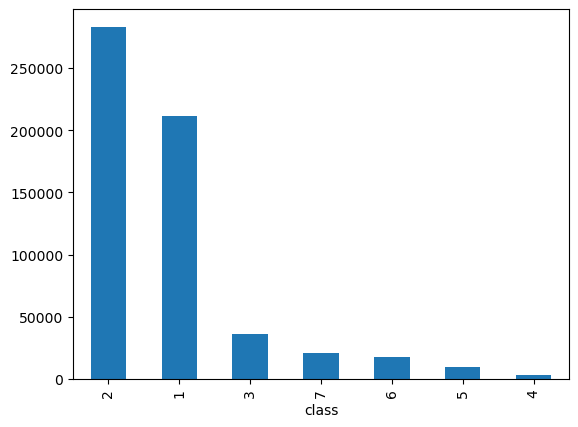

In [86]:
#Distribution of Y
Y.value_counts().plot(kind='bar')

When inspecting the distribution of the target variable (cover type) we can see a fairly imbalenced set of values here. This indicates that we will have to do some stratification of data when splitting the data into training and testing sets.

array([[<Axes: title={'center': 'Elevation'}>,
        <Axes: title={'center': 'Aspect'}>,
        <Axes: title={'center': 'Slope'}>],
       [<Axes: title={'center': 'Horizontal_Distance_To_Hydrology'}>,
        <Axes: title={'center': 'Vertical_Distance_To_Hydrology'}>,
        <Axes: title={'center': 'Horizontal_Distance_To_Roadways'}>],
       [<Axes: title={'center': 'Hillshade_9am'}>,
        <Axes: title={'center': 'Hillshade_Noon'}>,
        <Axes: title={'center': 'Hillshade_3pm'}>],
       [<Axes: title={'center': 'Horizontal_Distance_To_Fire_Points'}>,
        <Axes: >, <Axes: >]], dtype=object)

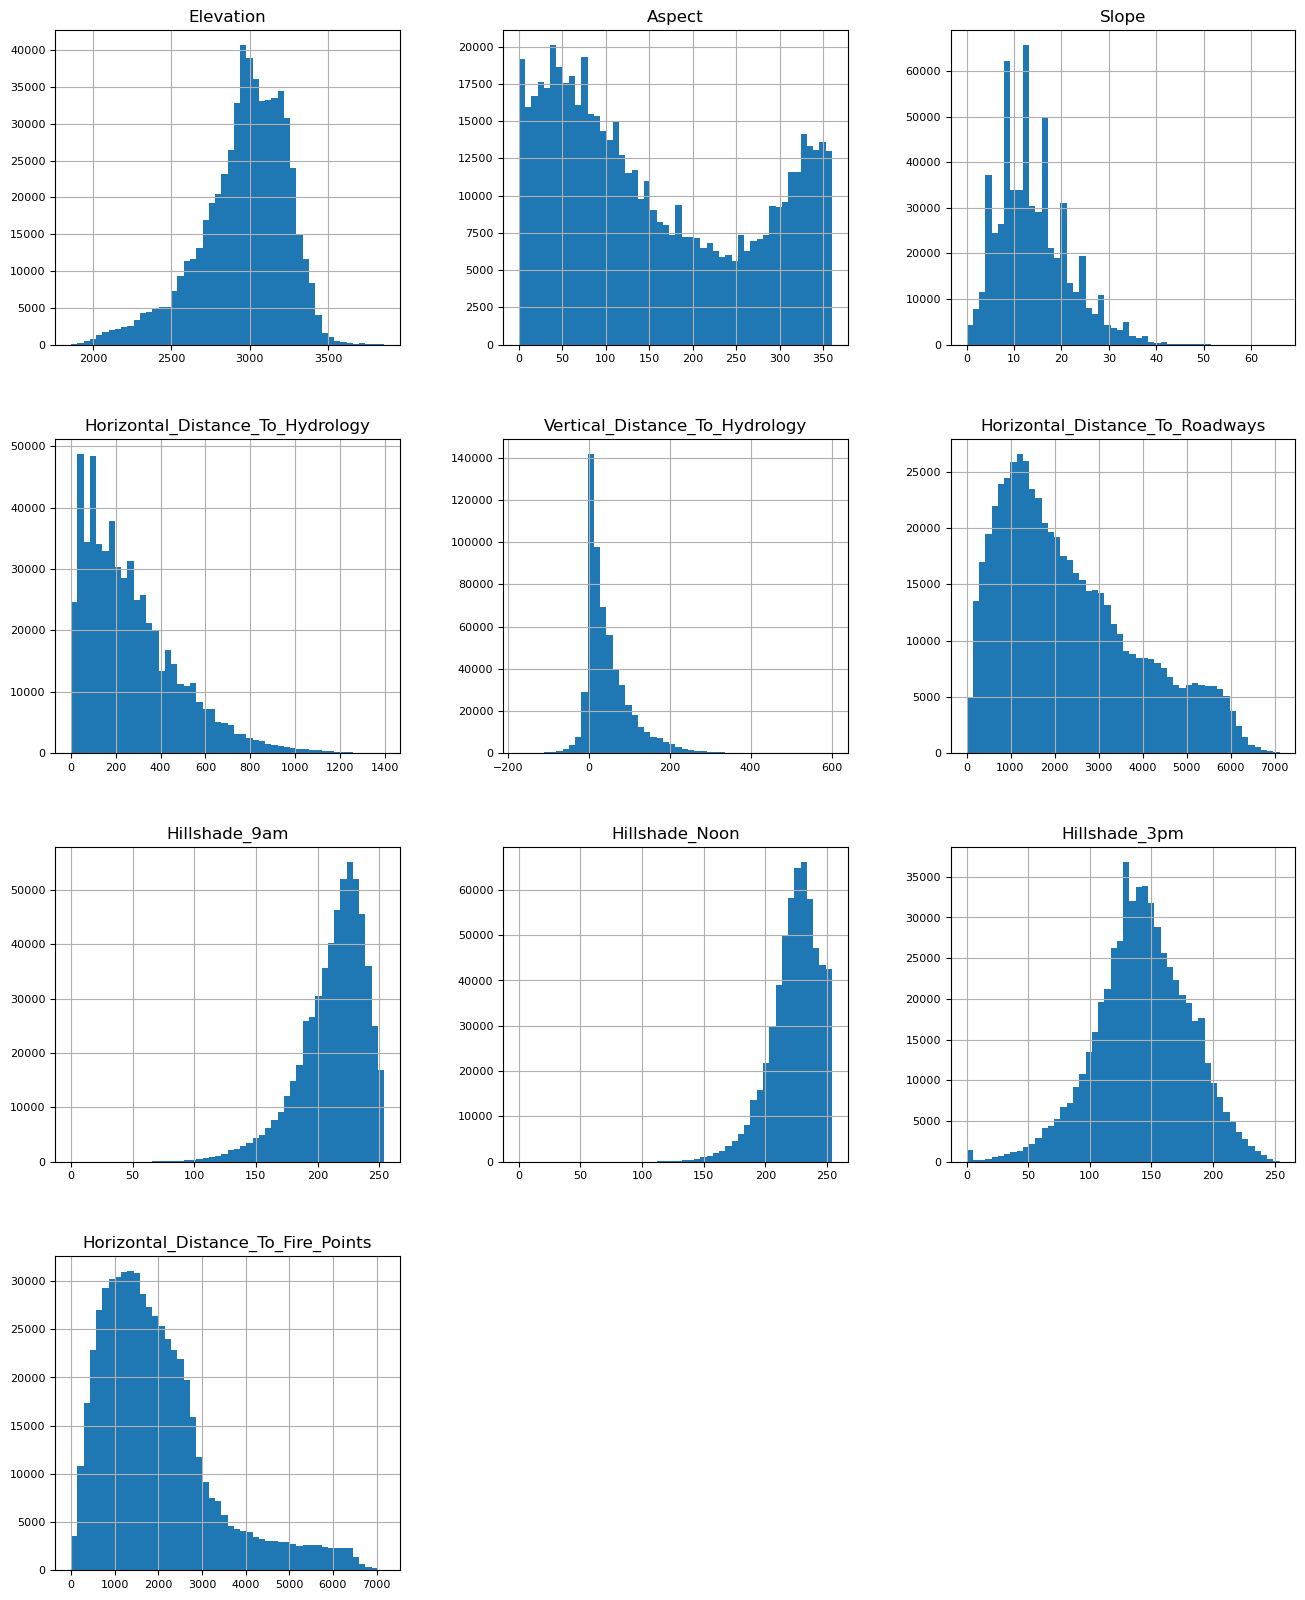

In [6]:
#Distribution of numerical data
X_numerical = X.iloc[:,0:10]
X_numerical.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

<Axes: >

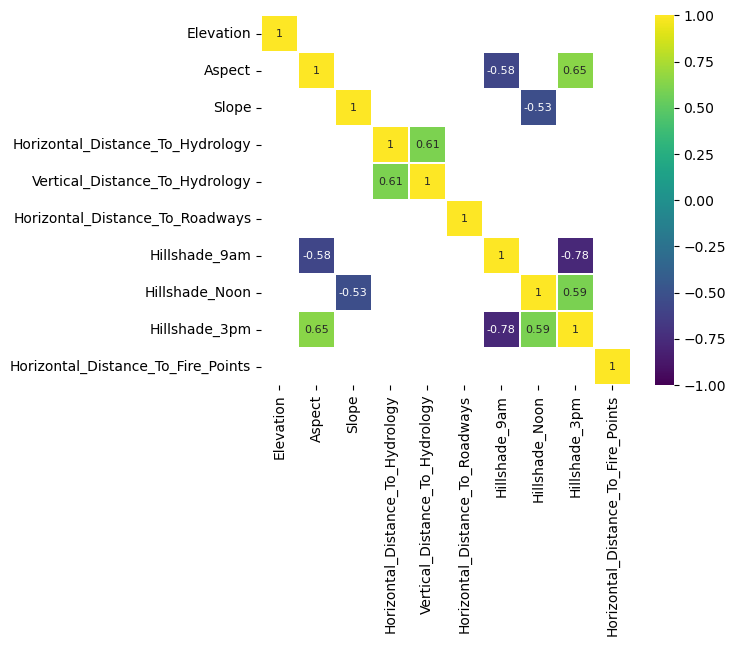

In [7]:
#Checking for correlations in numerical data
corr = X_numerical.corr()
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', 
            vmax=1.0, 
            vmin=-1.0, 
            linewidths=0.1, 
            annot=True, 
            annot_kws={"size": 8}, 
            square=True)

Strong correlations between Hillshade and Aspect for morning and afternoons, while Hillshade in the middle of the day correlates more closely with slope. These correlations make sense as the direction of the forrest cover will affect its shadow at different times of the day. If the sun is directly above then slope will be the main factor affecting hillshade We can delete highly correlated features as they can negatively affect some models. 'Hillshade_9am' and 'Hillshade_3pm' are highly correlated, so we could look at deleting one of these.

# Preparing, Building and Testing the Model

In [92]:
#Functions
def prep_data(raw_df,test_size):
    X = raw_data.iloc[:,0:-1]
    Y = raw_data.iloc[:,-1]
    
    #split the data
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=test_size,random_state=42,stratify=Y)
    
    #Scale numerical columns
    numerical_cols = X.columns[0:10]
    ct = ColumnTransformer([('standardize', StandardScaler(),numerical_cols)], remainder='passthrough')
    x_train = ct.fit_transform(x_train)
    x_test = ct.transform(x_test)
    
    return x_train, x_test, y_train, y_test


def plot_history(history):
    plt.subplot(1,2,1)
    #Accuracy Plot
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    #Loss Plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()
    return

def evaluate_model(model):
    score = model.evaluate(x_test, y_test, verbose=False)
    print("Test set results\nLoss: {0}\n Accuracy: {1}".format(score[0], score[1]))
    
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = y_test

    class_names = ['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

    print(classification_report(y_true, y_pred, target_names=class_names))
    return

def heat_map(class_names, y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

In [93]:
#Prep full data set
x_train, x_test, y_train, y_test = prep_data(raw_data,0.33)

We will first get an understanding of the model performance with simple, un-tuned parameters. Setting our learning rate to 0.01, epochs to 100, batch_size to 10000, optimizer to Adam and number of nearons to 24 as a first point of call.  

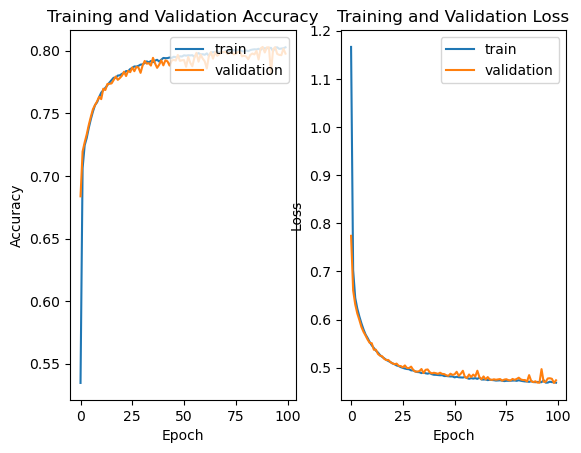

Final accuracy score: 0.7976006865501404


In [89]:
#Basic model with 1 hidden layer

epochs = 100
batch_size = 10000
learning_rate = 0.01
neurons = 24

def basic_model(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

#Build the model
basic_model = basic_model(x_train.shape[1])
history = basic_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.1)
plot_history(history)
print("Final accuracy score: {0}".format(history.history['val_accuracy'][-1]))

I will now tune these hyperparameters to improve our model performance. To do this i will use the sklearn modeule "GridSearchCV". GridSearchCV itterates through a defined set of parameters, assesses performance using cross validation, and returns the best performing combination of parameters. Since this process is very computationally expensive, i created a reduced set of x_train and y_train to get an understanding of which way the parameters were heading. As well as the grid search i also did some manual testing, as it became apparent after a while what the better params were.

In [ ]:
#Reduced x_train and y_train
x_train_reduced, x_test_increased, y_train_reduced, y_test_increased = prep_data(raw_data,0.8)

#Hyperparameter Tuning Example
epochs = [50,100,300]
batch_size = [20000]
learning_rate = [0.01,0.1,0.3]
neurons = [20,120,200]

def tuner_model(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

param_grid = dict(model__neurons=neurons,
                 epochs=epochs,
                 batch_size=batch_size,
                 optimizer__learning_rate=learning_rate)

#Build the model
tuner_model = tuner_model(x_train_reduced.shape[1])
estimator = KerasClassifier(model=tuner_model, verbose=0)
grid = GridSearchCV(estimator, param_grid=param_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_result = grid.fit(x_train_reduced, y_train_reduced)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

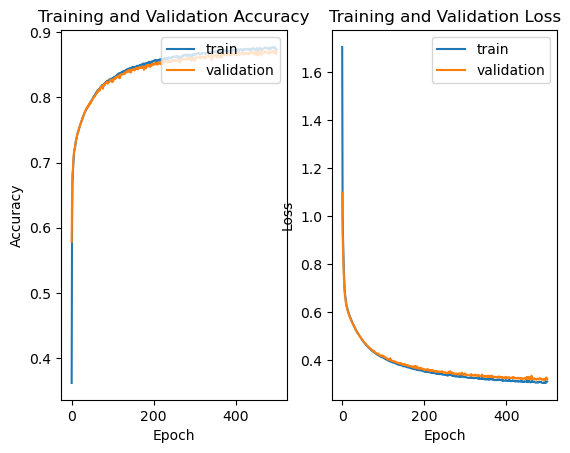

Final accuracy score: 0.869399905204773


In [90]:
#Final Parameters with 1 layer model

epochs = 500
batch_size = 100000
learning_rate = 0.01
neurons = 124
optimizer = 'Adam'

def basic_model(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

#Build the model
basic_model = basic_model(x_train.shape[1])
history = basic_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.1)
plot_history(history)
print("Final accuracy score: {0}".format(history.history['val_accuracy'][-1]))

Performance has improved significantly from baseline, increasing by aprox 7% points. The model appears to generalise quite well also which is evident by the validation loss remaing close to the training loss throughout epochs.
Now that i am fairly confident that ive exhausted the use of these parameters for tuning, i will test the performance of adding more layers to our model.

Final accuracy score: 0.9072903990745544


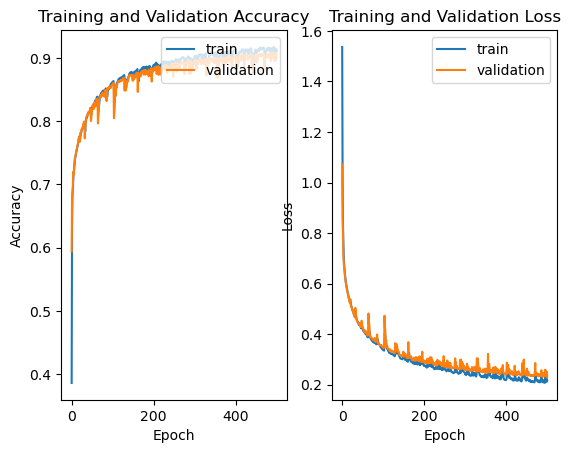

Final accuracy score: 0.9072903990745544


In [63]:
#Testing a more complex model with 2 layers 

epochs = 500
batch_size = 100000
learning_rate = 0.01
neurons = 124
optimizer = 'Adam'

def model_2(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    #Hidden Layer 2
    model.add(Dense(neurons,activation='relu'))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

#Build the model
model_2 = model_2(x_train.shape[1])
#We add early stopping to ensure the model stops training if performance begins to decrease with the more epochs
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)
history = model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.1, callbacks=[es])
plot_history(history)
print("Final accuracy score: {0}".format(history.history['val_accuracy'][-1]))

This model performs better than our single layer model, i will again increase to a 3 layer model to see if this trend in performance continues.

Epoch 248: early stopping


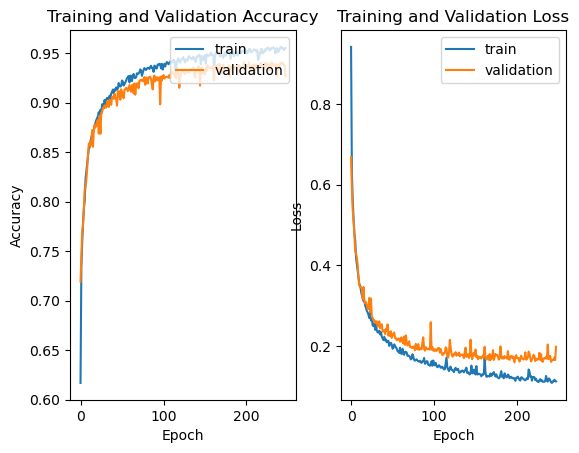

Final accuracy score: 0.9264539480209351


In [94]:
#More complex model with 3 layers 
epochs = 250
batch_size = 15000
learning_rate = 0.01
neurons = 124

def model_3(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    #Hidden Layer 2
    model.add(Dense(neurons,activation='relu'))
    #Hidden Layer 3
    model.add(Dense(neurons,activation='relu'))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

#Build the model
model_3 = model_3(x_train.shape[1])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = model_3.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.1,callbacks=[es])
plot_history(history)
print("Final accuracy score: {0}".format(history.history['val_accuracy'][-1]))


The 3 layer model gains a further 2.6% points of accuracy improvement on the 2 layer model. This does come at the cost of computational power though with an increase in training parameters from X to Y. We also note some overfitting occuring which is evident in the validation loss deviating further from the training loss at higher epochs. I will use some regularization techniques such as "Dropout" to see if we can get the model to generalize better.

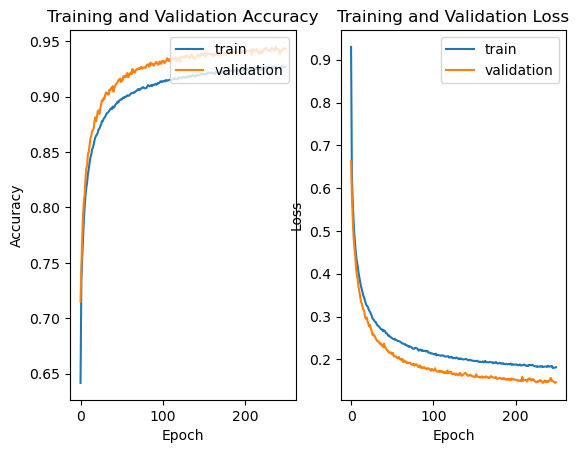

Final accuracy score: 0.9430487155914307


In [100]:
#More complex model with 3 layers and dropout regularization
epochs = 250
batch_size = 15000
learning_rate = 0.01
neurons = 124

def model_3_dropout(num_features):
    model = Sequential()
    #Input Layer
    model.add(InputLayer(input_shape = (num_features,)))
    #Hidden Layer 1
    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(0.05))
    #Hidden Layer 2
    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(0.05))
    #Hidden Layer 3
    model.add(Dense(neurons,activation='relu'))
    #model.add(Dropout(0.05))
    #Output Layer
    model.add(Dense(8,activation='softmax'))
    
    opt = Adam(learning_rate = learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
    return model

#Build the model
model_3_dropout = model_3_dropout(x_train.shape[1])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = model_3_dropout.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.1,callbacks=[es])
plot_history(history)
print("Final accuracy score: {0}".format(history.history['val_accuracy'][-1]))

Adding the dropout regularization gives us slightly better results than without it. The main difference is in the varience or smoothness of the learning curve, which appears to be alot less volitile, leading to a model with more stable predictions. The training loss curve has risen above the validation curve here. One explaination could be that the dropout is only being performed on the training set and not the validation set.

In [101]:
#Saving the final model
final_model = model_3_dropout
final_model.save('ForrestCover.keras')

# Evaluating model on test data


Test set results
Loss: 0.14972160756587982
 Accuracy: 0.9411007165908813
5992/5992 [==============================] - 4s 678us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.95      0.93      0.94     69907
   Lodgepole Pine       0.94      0.96      0.95     93489
   Ponderosa Pine       0.94      0.94      0.94     11799
Cottonwood/Willow       0.89      0.81      0.85       907
            Aspen       0.85      0.82      0.84      3133
      Douglas-fir       0.88      0.91      0.89      5731
        Krummholz       0.93      0.96      0.95      6768

         accuracy                           0.94    191734
        macro avg       0.91      0.90      0.91    191734
     weighted avg       0.94      0.94      0.94    191734



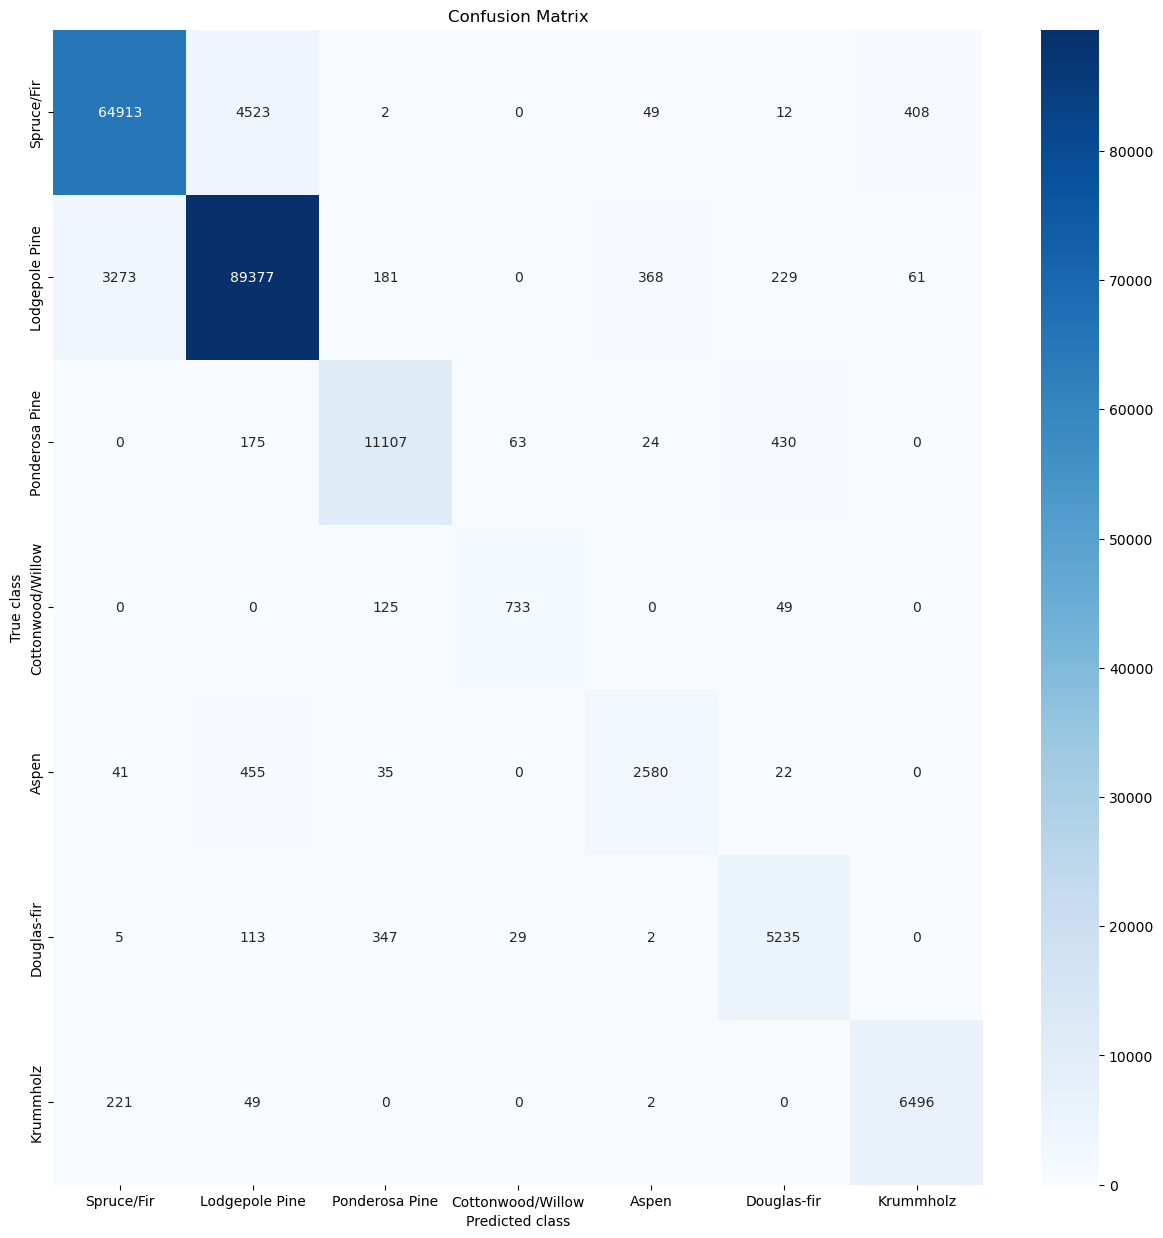

In [103]:
import keras
#Load my model
model = keras.models.load_model('ForrestCover.keras')

#evaluate model on the test data
score = model.evaluate(x_test, y_test, verbose=False)
print("Test set results\nLoss: {0}\nAccuracy: {1}".format(score[0], score[1]))
    
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

class_names = ['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

#Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))
#Heatmap
heat_map(class_names, y_pred, y_true)

### Summary:
Overall we have achieved strong classification performance with an F1-score of 0.94 on our testing set. I have chosen to report on F1-score since our data set is imbalenced, and F1-score takes this in to account.
From the classification and heatmap reports we can see that our model is most preficient at classifying the majority classes of Spruce/Fir and Lodgepole Pine as well as some of the smaller classes such as Ponderosa Pine and Krummholz. Our model dosnt do so well on the three smallest classes such as Cottonwood/Willow, Aspen and Douglas-fir. This is because the wieghts of our model will be most influenced by the majority classes, so the minority classes wont be as 'built in' to the model. 

#### How missclasifications could be improved:
Some techniques for improving missclassifications our imbalenced class set include:
* Resampling - create more samples of minority classes by sampling 'with replacement' on the minority class's (or under-sampling from the majority class
* Creating synthetic samples of minority classes with techniques such as SMOTE (Synthetic Minority Oversampling Technique)
* Wieghting minority classes higher
* Removing any colinearities that exist between feature variables
